<a href="https://colab.research.google.com/github/mingmingbupt/tensorflow/blob/master/tf_keras_to_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0-rc2
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.2
pandas 1.0.3
sklearn 0.22.2.post1
tensorflow 2.2.0-rc2
tensorflow.keras 2.3.0-tf


In [2]:
#如何在colab上使用在google cloud上面的文件
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Colab Notebooks/tensorflow/Tensorflow2.0--rumendaoshijian/chapter_5"

os.chdir(path)
os.listdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


['tf_premade_estimators-new_feature.ipynb',
 'tf_premade_estimators.ipynb',
 'data',
 'tf_keras_to_estimator.ipynb']

In [3]:
# https://storage.googleapis.com/tf-datasets/titanic/train.csv
# https://storage.googleapis.com/tf-datasets/titanic/eval.csv
train_file = "./data/titanic/train.csv" #这里把缺失值做了填充 训练集
eval_file = "./data/titanic/eval.csv" #这里把缺失值做了填充  测试集

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())
print(eval_df.head())

   survived     sex   age  ...     deck  embark_town  alone
0         0    male  22.0  ...  unknown  Southampton      n
1         1  female  38.0  ...        C    Cherbourg      n
2         1  female  26.0  ...  unknown  Southampton      y
3         1  female  35.0  ...        C  Southampton      n
4         0    male  28.0  ...  unknown   Queenstown      y

[5 rows x 10 columns]
   survived     sex   age  ...     deck  embark_town  alone
0         0    male  35.0  ...  unknown  Southampton      y
1         0    male  54.0  ...        E  Southampton      y
2         1  female  58.0  ...        C  Southampton      y
3         1  female  55.0  ...  unknown  Southampton      y
4         1    male  34.0  ...        D  Southampton      y

[5 rows x 10 columns]


In [4]:
y_train = train_df.pop('survived') #因为survived是我们预测的值，是y，要取出来，同时在train_df里去掉
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch  ...  class     deck  embark_town alone
0    male  22.0                   1      0  ...  Third  unknown  Southampton     n
1  female  38.0                   1      0  ...  First        C    Cherbourg     n
2  female  26.0                   0      0  ...  Third  unknown  Southampton     y
3  female  35.0                   1      0  ...  First        C  Southampton     n
4    male  28.0                   0      0  ...  Third  unknown   Queenstown     y

[5 rows x 9 columns]
      sex   age  n_siblings_spouses  parch  ...   class     deck  embark_town alone
0    male  35.0                   0      0  ...   Third  unknown  Southampton     y
1    male  54.0                   0      0  ...   First        E  Southampton     y
2  female  58.0                   0      0  ...   First        C  Southampton     y
3  female  55.0                   0      0  ...  Second  unknown  Southampton     y
4    male  34.0                   0      0  ...  Second     

In [5]:
train_df.describe() #看下数据集里面的统计量，因为只有这四个是数值的，其他都是离散型的

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


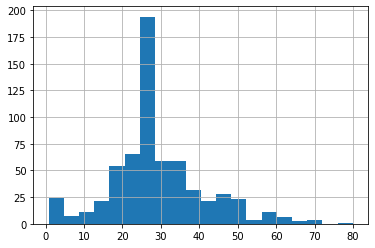

In [7]:
train_df.age.hist(bins = 20) #年龄分布，bins就是我把所有值分成多少份

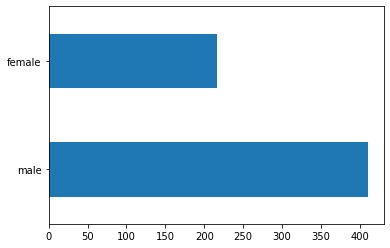

In [8]:
train_df.sex.value_counts().plot(kind = 'barh') #不同性别的人各占多少，画个柱状图，画一个横向的柱状图，横向就是kind=barh，纵向就是kind=barv

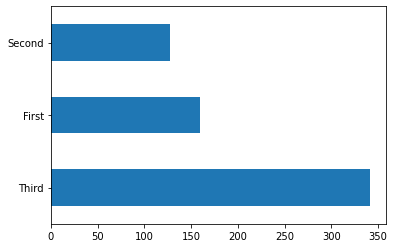

In [9]:
train_df['class'].value_counts().plot(kind = 'barh') #统计下不同仓位的乘客各有多少 #这里为什么用train_df['class']，
#而不是train_df.class呢，因为class跟dataframe的自带的函数冲突了，所以只能用这种方式来取数据了

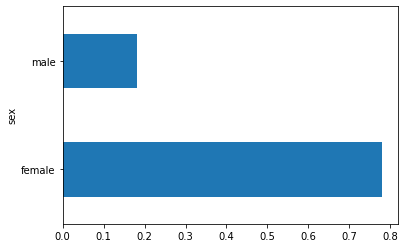

In [10]:
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind='barh') #男性中有多少获救了 女性中有多少获救了

In [11]:
# 使用feature_columns对数据进行封装
# feature_columns是专门针对列数据做封装的一种数据表达手法，如果列是离散值，可以很方便做onehoet编码
# 如果列是连续值，也很方便的做分桶，变成离散特征，如果需要的话

# 把特征分成两类特征，离散特征和连续特征
# 离散特征做onehot编码变成一个向量
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                       'deck', 'embark_town', 'alone']

#可以直接输入，也可以分桶，也可以做其他变换比如scaling
numeric_columns = ['age', 'fare']

feature_columns = [] #定义一个feature_column列表
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique() #获取这个离散特征所有可能的值
    print(categorical_column, vocab)
    #离散特征做onehot编码
    feature_columns.append(
        #做onehot编码需要调用tf.feature_column.indicator_column来实现
        #大家注意，feature_column下面的这些东西是可以嵌套的，做一个嵌套就是做一个处理
        tf.feature_column.indicator_column(
            #先定义一个feature_column
            tf.feature_column.categorical_column_with_vocabulary_list( 
                #tf.feature_column.categorical_column_with_vocabulary_list这个函数有两个参数
                categorical_column, vocab)))

for categorical_column in numeric_columns: #连续特征直接作为输入，直接用tf.feature_column.numeric_column
    feature_columns.append(
        tf.feature_column.numeric_column(
            categorical_column, dtype=tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [12]:
dict(train_df) #key 就是列名 value就是它的数据值

{'age': 0      22.0
 1      38.0
 2      26.0
 3      35.0
 4      28.0
        ... 
 622    28.0
 623    25.0
 624    19.0
 625    28.0
 626    32.0
 Name: age, Length: 627, dtype: float64, 'alone': 0      n
 1      n
 2      y
 3      n
 4      y
       ..
 622    y
 623    y
 624    y
 625    n
 626    y
 Name: alone, Length: 627, dtype: object, 'class': 0       Third
 1       First
 2       Third
 3       First
 4       Third
         ...  
 622    Second
 623     Third
 624     First
 625     Third
 626     Third
 Name: class, Length: 627, dtype: object, 'deck': 0      unknown
 1            C
 2      unknown
 3            C
 4      unknown
         ...   
 622    unknown
 623    unknown
 624          B
 625    unknown
 626    unknown
 Name: deck, Length: 627, dtype: object, 'embark_town': 0      Southampton
 1        Cherbourg
 2      Southampton
 3      Southampton
 4       Queenstown
           ...     
 622    Southampton
 623    Southampton
 624    Southampton
 625    Southamp

In [0]:
#构建dataset
#参数为 x y epoch 是否需要混排 batchsize
def make_dataset(data_df, label_df, epochs = 10, shuffle = True,
                 batch_size = 32):
    #构建数据集
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df)) #data_df是一个多列的pandas的dataframe结构
    if shuffle:
        dataset = dataset.shuffle(10000) #buffersize=10000
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset #返回x y

In [0]:
train_dataset = make_dataset(train_df, y_train, batch_size = 5)

In [15]:
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'male', b'male', b'male', b'male', b'female'], dtype=object)>, 'age': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([28., 29., 45., 39., 28.])>, 'n_siblings_spouses': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 0, 0, 1])>, 'parch': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 0])>, 'fare': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 7.8958, 66.6   , 35.5   ,  7.925 , 82.1708])>, 'class': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Third', b'First', b'First', b'Third', b'First'], dtype=object)>, 'deck': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'C', b'unknown', b'unknown', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Southampton',
       b'Cherbourg'], dtype=object)>, 'alone': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'y', b'n', b'y', b'y', b'n']

In [16]:
#feature column和dataset结合使用
# 在这里把他们联合起来的API呢是keras.layers.DenseFeature
# 这个keras.layers.DenseFeature可以把我们定义的feature_columns呢应用到dataset上去
# feature_columns呢本质上是一组对feature进行变换的规则，
#然后DenseFeature呢可以把这个规则应用到dataset的每一个数据上去
for x, y in train_dataset.take(1):
    age_column = feature_columns[7] #取出来age对应的feature_column
    gender_column = feature_columns[0] #再取出gender对应的feature_column
    #如何使用DenseFeatures把我们这个feature_column对应的规则应用到x上去
    print("x=",x)
    print(keras.layers.DenseFeatures(age_column)(x).numpy()) #直接调用keras.layers.DenseFeatures
    #参数是age_column,也就是我现在的DenseFeature现在只有age_column一个规则，然后我把它应用到x上去，然后我再取出它的numpy的值，然后打印出来
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())#同理呢我再把DenseFeatures用gender_column来初始化，来应用到我们的x上

x= {'sex': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'male', b'male', b'male', b'female', b'male'], dtype=object)>, 'age': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([28., 34., 33.,  5., 36.])>, 'n_siblings_spouses': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 1, 0, 0])>, 'parch': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 1, 0, 1])>, 'fare': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([  7.2292,  13.    ,  20.525 ,  12.475 , 512.3292])>, 'class': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Third', b'Second', b'Third', b'Third', b'First'], dtype=object)>, 'deck': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'unknown', b'unknown', b'B'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Cherbourg', b'Southampton', b'Southampton', b'Southampton',
       b'Cherbourg'], dtype=object)>, 'alone': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'y', b'y', b'n', b'y'

In [17]:
# keras.layers.DenseFeature
# 做一个全部的，也就是我们把feature_coloumns做为参数传给这个DenseFeatures
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[28.      0.      1.      0.      1.      0.      0.      0.      0.
   1.      0.      0.      0.      0.      1.      0.      0.      0.
  26.      0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      1.      0.    ]
 [34.      0.      1.      0.      0.      1.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
  13.      0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.

In [0]:
#构建keras模型
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),#第一层变成DenseFeatures
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = keras.optimizers.SGD(lr=0.01),
              metrics = ['accuracy'])


In [21]:
# 模型定义好以后有两种方式
# 1. model.fit 
# 2. model -> estimator -> train把model转成estimator,然后再用estimator去训练模型

train_dataset = make_dataset(train_df, y_train, epochs = 100) #初始化训练集dataset
eval_dataset = make_dataset(eval_df, y_eval, epochs = 1, shuffle = False) #生成验证的dataset
history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                    steps_per_epoch = 20, #训练集样本数//batch_size
                    validation_steps = 8, #验证机数量//batch_size
                    epochs = 100) 

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 0s 16ms/step - loss: 2.5663 - accuracy: 0.5750 - val_loss: 0.6339 - val_accuracy: 0.6836
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.7834 - accuracy: 0.6531 - val_loss: 0.6339 - val_accuracy: 0.6562
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6359 - val_loss: 0.7151 - val_accuracy: 0.6172
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6347 - ac

AttributeError: ignored

In [22]:
# 2.使用第二种方法将keras转成estimator进行训练
estimator = keras.estimator.model_to_estimator(model) #调用keras.estimator.model_to_estimator将keras转成estimator
# 1. function
# 2. return a. (features, labels) b. dataset -> (feature, label)
estimator.train(input_fn = lambda : make_dataset(
    train_df, y_train, epochs=100)) #在estimator里如何训练呢，input_fn是一个函数，可以是具体函数，也可以是lambda匿名函数，
    #input_fn返回的结果呢，必须是以下几种
    # 1 (features, labels)组成的元组，这里面features,lables可以是列表，也可以是numpy数组等等
    # 2. 可以是dataset,dataset里面的数据呢，必须是(feature, label)
    # 这就是input_fn的要求
    # 之前我们定义了一个make_dataset,这个make_dataset就能够返回这样一个dataset.它里面的值就是featur和label
    # 但是make_dataset是有参数的，而我们input_fn是要求没有参数的，所以我们使用一个lambda表达式对这个make_dataset做一个封装
    # 让他变成没有参数的函数

#得到了一个错误，错误提示 数据中的case和我期望的case不一样，我期望得到的case是input_3, input_9, input_6等等
#这个期望得到的case是什么，是我们在定义model的时候这个feature_columns.而我们知道，在我们的feature_columns里面
#他们都是一些具体的值，比方说age，gender等等，但是他在这里却把这些值变成了input_3, input_2, input_9等等
#所以说呢，他里面真正feature_columns的名字呢没有被保存下来，而我们数据中呢，则是真正的column的名字，这里不匹配，这也是
#tensorflow2.0的bug 这是tensorflow框架的bug




INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpl75nx6es', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas':

ValueError: ignored